
# Dow index Time Series Forecasting with auto ARIMA

In my previous post

see https://github.com/kyramichel/Math_Finance/blob/master/PCA%20app.ipynb

I looked at the composition of the Dow Jones Industrial Average (^DJI - a stock market index that measures the stock performance of the top 30 largest companies listed on US stock exchanges -


In this post I will build an ARIMA auto ARIMA model to predict the Dow Jones index. 


**ARIMA (AutoRegressive Integrated Moving Average)** - the classic ARIMA (p,q,d) framework for Time Series forecasting
 
Here (p,q,d) are hyperparameters that need to be determined when building an ARIMA model. These parameters are calculated based on past data. 

CONS: While ARIMA model is built on a mathematical model, ARIMA, like Moving Averages, uses business judgement for the selection of how many past values should be used. 

The classic approach for finding (p,q, d) is to examine the ACF and PACF charts. 

A more efficient way is to use Auto ARIMA that will automatically return the the most optimal hyperparameters.(see below)

In [ ]:
#imports

import math
import pandas as pd
import numpy as np

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import pandas_datareader.data as web

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Dow Jones index since Jan 1,2020 (COVID19 started) 

dow = pdr.get_data_yahoo('^DJI', '2020-01-01')
dow['Adj Close']

Date
2020-01-02    28868.800781
2020-01-03    28634.880859
2020-01-06    28703.380859
2020-01-07    28583.679688
2020-01-08    28745.089844
                  ...     
2022-08-01    32798.398438
2022-08-02    32396.169922
2022-08-03    32812.500000
2022-08-04    32726.820312
2022-08-05    32803.468750
Name: Adj Close, Length: 654, dtype: float64

<AxesSubplot:xlabel='Date'>

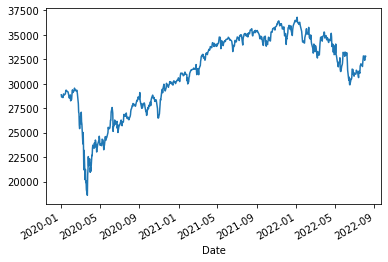

In [ ]:
dow['Adj Close'].plot()

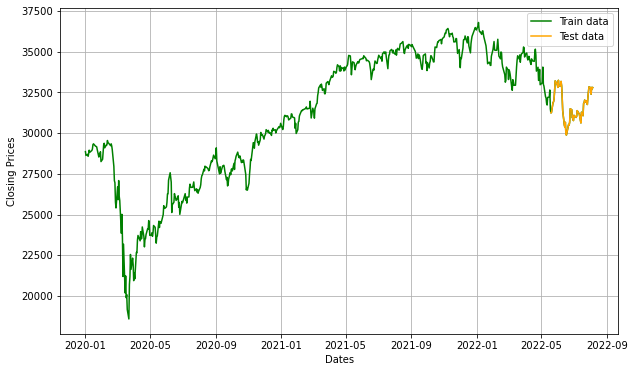

In [ ]:
# Splitting the data into training and testing:

train_data, test_data = dow['Adj Close'][3:600], dow['Adj Close'][600:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(dow['Adj Close'], 'green', label='Train data')
plt.plot(test_data, 'orange', label='Test data')
plt.legend()

Stationarity is a pre-requisite for ARIMA models.

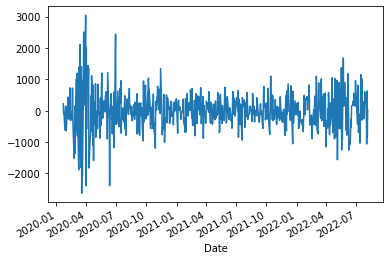

In [ ]:
# Adding a seasonal differencing term to remove the trend 

dow['Adj Close'].diff().diff(periods=12).plot();

d - the minimum number of differencing needed to make the series stationary. (if time series is already stationary: d = 0)

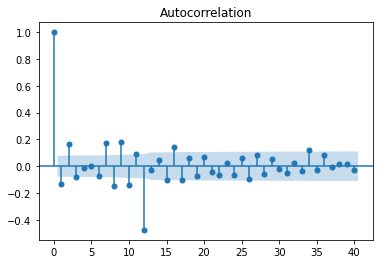

In [ ]:
# One way to find tge (p,q) params: AR(p) and MA(q), is using the plots for autocorrelation and partial autocorrelation:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_data = dow['Adj Close'].diff().diff(periods=12)[13:]
x = plot_acf(stationary_data, lags=40)

The above charts shows one significant autocorrelation lag around lag 12

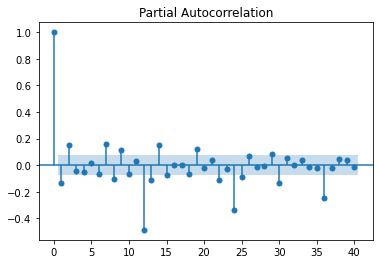

In [ ]:
x = plot_pacf(stationary_data, lags=40)

Each spike (lag) which is above the dashed area is considered to be statistically significant. As per above charts: see lag 12, 24, 36..

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8923.059, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8905.791, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8909.937, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8921.137, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8896.492, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8898.446, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8898.481, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8901.510, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8876.064, Time=1.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8859.880, Time=2.49 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8860.171, Time=1.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8862.823, Time=2.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8900.594, Time=2.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=8857.946, Time=1.22 sec
 ARIMA(2,1,2)(0,0,0)[0]          

In [ ]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  597
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -4422.973
Date:                Sun, 07 Aug 2022   AIC                           8857.946
Time:                        12:37:26   BIC                           8884.287
Sample:                             0   HQIC                          8868.203
                                - 597                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6305      0.061    -26.624      0.000      -1.751      -1.510
ar.L2         -0.7231      0.083     -8.723      0.000      -0.886      -0.561
ar.L3          0.0744      0.032      2.300      0.021       0.011       0.138
ma.L1          1.5589      0.056     27.795      0.000       1.449       1.669
ma.L2          0.6999      0.053     13.315      0.000       0.597       0.803
sigma2      1.599e+05   5266.272     30.366      0.000     1.5e+05     1.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):               788.48
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

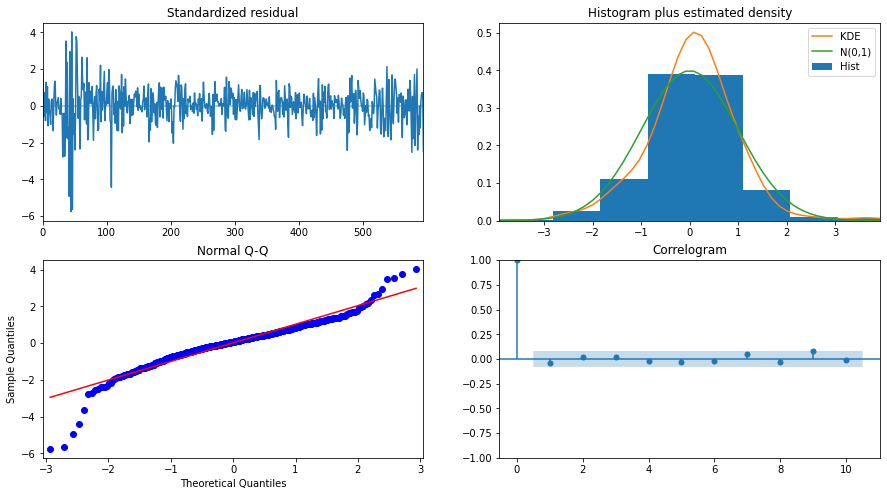

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

The Auto ARIMA model identified as:

Best model:  ARIMA(3,1,2)(0,0,0)

#Modeling
#Build Model
model = ARIMA(train_data, order=(3,1,2))  


In [ ]:
# fit the model
arima_model = ARIMA(train_data, order=(3,1,2))  

res = arima_model.fit(disp=-1)  

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  596
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -4418.398
Method:                       css-mle   S.D. of innovations            401.002
Date:                Sun, 07 Aug 2022   AIC                           8850.796
Time:                        12:45:54   BIC                           8881.528
Sample:                             1   HQIC                          8862.763
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.1188     16.052      0.319      0.750     -26.342      36.580
ar.L1.D.Adj Close    -1.6405      0.084    -19.605      0.000      -1.805      -1.477
ar.L2.D.Adj Close    -0.

In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Adj Close   No. Observations:                  653
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4865.799
Method:                       css-mle   S.D. of innovations            416.747
Date:                Sun, 07 Aug 2022   AIC                           9739.598
Time:                        12:12:43   BIC                           9757.524
Sample:                             1   HQIC                          9746.549
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.0434     14.401      0.420      0.675     -22.182      34.269
ar.L1.D.Adj Close    -0.5051      0.099     -5.122      0.000      -0.698      -0.312
ma.L1.D.Adj Close     0.3289      0.104      3.170      0.002       0.126       0.532
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9797           +0.0000j            1.9797            0.5000
MA.1           -3.0403           +0.0000j            3.0403            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# ARIMA forecast
forc, se, conf = res.forecast(54, alpha=0.05)  # using 95% conf int

Text(0.5, 1.0, 'Forecasting Dow Jones index with ARIMA')

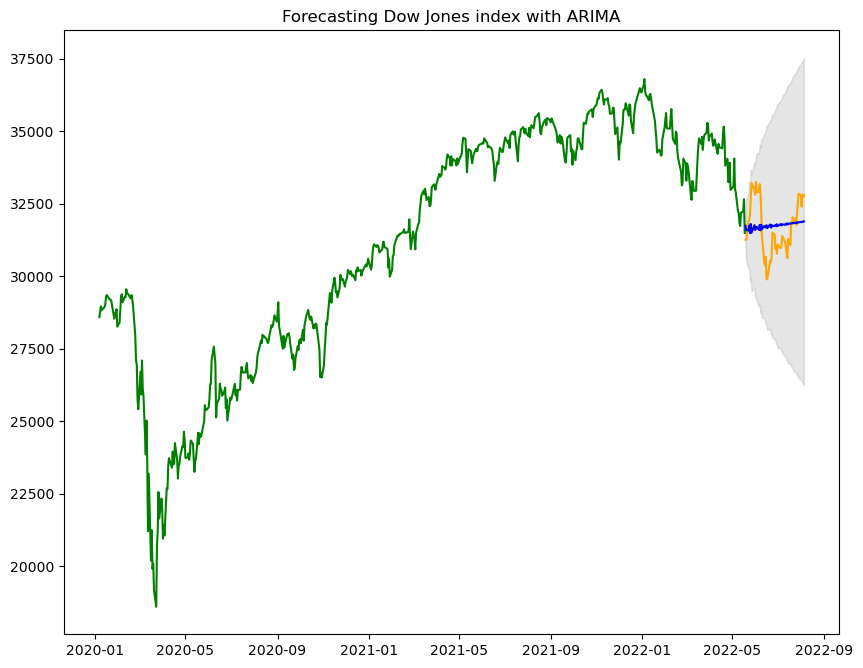

In [ ]:
#plot
forc_series = pd.Series(forc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,8), dpi=100)
plt.plot(train_data, color = 'green')
plt.plot(test_data, color = 'orange', label='Actuals')
plt.plot(fc_series, color = 'blue',label='Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Forecasting Dow Jones index with ARIMA')
